# Midterm

In [62]:
import secrets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from scipy import stats

# sns.set_style("whitegrid")

In [2]:
data_path = Path().resolve().parent / "data"

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
# Random seed for reproducibility
# secrets.randbits(128) # 208905213533139122735706682150229709525
rng = np.random.default_rng(208905213533139122735706682150229709525)
indices_train = rng.choice(5000, 2500, replace=False)
indices_test = rng.choice(800, 400, replace=False)
flag_full_dataset = True  # If it is True it will use full train and test datasets

In [5]:
train_list = []  # Auxiliary list of train datasets
for f in data_path.glob("train*.txt"):
    # Sample or full dataset
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_train, :]
    target = raw_data[:, [0]]  # Target values, i.e. digit
    features = raw_data[:, 1:] / raw_data[:, 1:].max(axis=1, keepdims=True)
    train_list.append(np.hstack((target, features)))  # Add to the temp list
train_data = np.vstack(train_list)  # Concatenate train datasets
train_data.shape

(60000, 785)

In [6]:
# Similar to train dataset
test_list = []
for f in data_path.glob("test*.txt"):
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_test, :]
    target = raw_data[:, [0]]
    features = raw_data[:, 1:] / raw_data[:, 1:].max(axis=1, keepdims=True)
    test_list.append(np.hstack((target, features)))
test_data = np.vstack(test_list)
test_data.shape

(10000, 785)

In [7]:
# Split datasets into features matrices and target vectors
X_train = train_data[:, 1:]
y_train = train_data[:, 0].astype(int)
X_test = test_data[:, 1:]
y_test = test_data[:, 0].astype(int)
y_train_encoded = pd.get_dummies(y_train).to_numpy()

In [8]:
display(y_train[:5])
display(pd.get_dummies(y_train).head())

array([0, 0, 0, 0, 0])

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [9]:
def forward(x, W_hidden, bias_hidden, W_output, bias_output):
    hidden = sigmoid(W_hidden @ x + bias_hidden)
    output = sigmoid(W_output @ hidden + bias_output)
    return hidden, output


def backward(x, target, W_hidden, bias_hidden, W_output, bias_output, hidden, output, eta):
    # Errors
    delta_output = output * (1 - output) * (target - output)
    delta_hidden = hidden * (1 - hidden) * W_output.T @ delta_output
    # Update
    D_W_hidden = eta * delta_hidden @ x.T
    D_bias_hidden = eta * delta_hidden
    D_W_output = eta * delta_output @ hidden.T
    D_bias_output = eta * delta_output
    W_hidden = W_hidden + D_W_hidden
    bias_hidden = bias_hidden + D_bias_hidden
    W_output = W_output + D_W_output
    bias_output = bias_output + D_bias_output
    return W_hidden, bias_hidden, W_output, bias_output


def trainning(X_train, y_train, n_hidden, epochs, eta, init_min, init_max):
    n_samples, n_feature = X_train.shape
    n_output = np.unique(y_train).size  # Unique number of digits/classes
    # Initialization
    W_hidden = np.random.uniform(init_min, init_max, size=(n_hidden, n_feature))
    bias_hidden = np.random.uniform(init_min, init_max, size=(n_hidden, 1))
    W_output = np.random.uniform(init_min, init_max, size=(n_output, n_hidden))
    bias_output = np.random.uniform(init_min, init_max, size=(n_output, 1))
    # Iteration
    errors = []
    for j in range(epochs):
        idx_permutation = np.random.permutation(n_samples)
        X_train = X_train[idx_permutation, :]
        y_train = y_train[idx_permutation]
        y_train_encoded = pd.get_dummies(y_train).to_numpy()
        for i in range(n_samples):
            x = X_train[i:i + 1, :].T
            target = y_train_encoded[i:i + 1, :].T
            hidden, output = forward(x, W_hidden, bias_hidden, W_output, bias_output)
            W_hidden, bias_hidden, W_output, bias_output = backward(
                x,
                target,
                W_hidden,
                bias_hidden,
                W_output,
                bias_output,
                hidden,
                output,
                eta
            )
        y_pred_train = predict(X_train, W_hidden, bias_hidden, W_output, bias_output)
        error = 1- accuracy(y_pred_train, y_train)
        errors.append(error)
        # if (j + 1) % 10 == 0:
        #     print(f"Epoch {j + 1} - Train error: {error:.3f}")
    return W_hidden, bias_hidden, W_output, bias_output, np.array(errors)


def predict(X, W_hidden, bias_hidden, W_output, bias_output):
    y_pred = np.empty(shape=X.shape[0])
    for k in range(X.shape[0]):
        _, pred = forward(X[k:k + 1, :].T, W_hidden, bias_hidden, W_output, bias_output)
        y_pred[k] = pred.argmax()
    return y_pred


def accuracy(y_pred, y_real):
    return np.mean(y_pred == y_real)

In [10]:
n_hidden = 3
epochs = 100
eta = 0.05
init_min = -0.05
init_max = 0.05
# W_hidden, bias_hidden, W_output, bias_output, errors = trainning(
#     X_train,
#     y_train,
#     n_hidden,
#     epochs,
#     eta,
#     init_min,
#     init_max
# )

In [12]:
train_errors_dict = {}
test_error_dict = {}
pred_dict = {}
n_hiddens = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_hidden in n_hiddens:
    W_hidden, bias_hidden, W_output, bias_output, train_errors = trainning(
        X_train,
        y_train,
        n_hidden,
        epochs,
        eta,
        init_min,
        init_max
    )
    y_pred = predict(X_test, W_hidden, bias_hidden, W_output, bias_output)
    test_error = accuracy(y_pred, y_test)
    train_errors_dict[n_hidden] = train_errors
    test_error_dict[n_hidden] = test_error
    pred_dict[n_hidden] = y_pred

Epoch 10 - Train error: 0.586
Epoch 20 - Train error: 0.555
Epoch 30 - Train error: 0.573
Epoch 40 - Train error: 0.559
Epoch 50 - Train error: 0.589
Epoch 60 - Train error: 0.549
Epoch 70 - Train error: 0.552
Epoch 80 - Train error: 0.528
Epoch 90 - Train error: 0.536
Epoch 100 - Train error: 0.569
Epoch 10 - Train error: 0.419
Epoch 20 - Train error: 0.415
Epoch 30 - Train error: 0.407
Epoch 40 - Train error: 0.407
Epoch 50 - Train error: 0.385
Epoch 60 - Train error: 0.387
Epoch 70 - Train error: 0.385
Epoch 80 - Train error: 0.383
Epoch 90 - Train error: 0.370
Epoch 100 - Train error: 0.397
Epoch 10 - Train error: 0.337
Epoch 20 - Train error: 0.332
Epoch 30 - Train error: 0.329
Epoch 40 - Train error: 0.270
Epoch 50 - Train error: 0.249
Epoch 60 - Train error: 0.260
Epoch 70 - Train error: 0.250
Epoch 80 - Train error: 0.266
Epoch 90 - Train error: 0.265
Epoch 100 - Train error: 0.258
Epoch 10 - Train error: 0.128
Epoch 20 - Train error: 0.127
Epoch 30 - Train error: 0.115
Epoch 4

In [25]:
train_error_df = (
    pd.DataFrame(train_errors_dict)
    .assign(epoch=lambda x: x.index + 1)
    .melt(id_vars="epoch", var_name="n_hidden", value_name="error")
)
train_error_df.head()

,epoch,n_hidden,error
0,1,2,0.794117
1,2,2,0.778550
2,3,2,0.676967
3,4,2,0.652167
4,5,2,0.635817


In [31]:
# train_error_df.to_csv("train_error.csv")

/tmp/ipykernel_5920/237979470.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


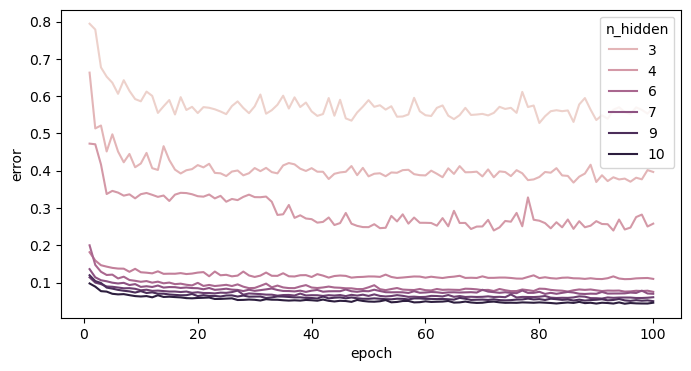

In [30]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(
    data=train_error_df,
    x="epoch",
    y="error",
    hue="n_hidden",
    ax=ax
)
fig.show()

In [58]:
test_accuracy = np.array(list(test_error_dict.values()))
test_sigma = np.sqrt(test_accuracy * (1 - test_accuracy) / y_test.size)
test_error_lower =  1.96 * test_sigma
test_error_upper =  1.96 * test_sigma
asymmetric_error = [test_error_lower, test_error_upper]


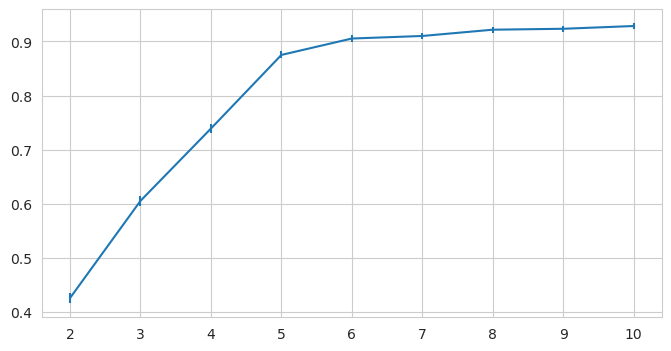

In [60]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(
    n_hiddens,
    test_accuracy,
    yerr=asymmetric_error
)
# ax1.set_title('variable, asymmetric error')
plt.show()

In [63]:
y_pred = pred_dict[n_hiddens[-1]]
error_h = accuracy(y_pred, y_test)
sigma = np.sqrt(error_h * (1 - error_h) / y_test.size)
print(f"Accuracy with {n_hiddens[-1]} hidden layers was {error_h:.2%} and with approximately 95% probability the true error lies in the interval [{error_h - 1.96 * sigma:.4f}, {error_h + 1.96 * sigma:.4f}]")

Accuracy with 10 hidden layers was 92.84% and with approximately 95% probability the true error lies in the interval [0.9233, 0.9335]


/tmp/ipykernel_5920/2263963989.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


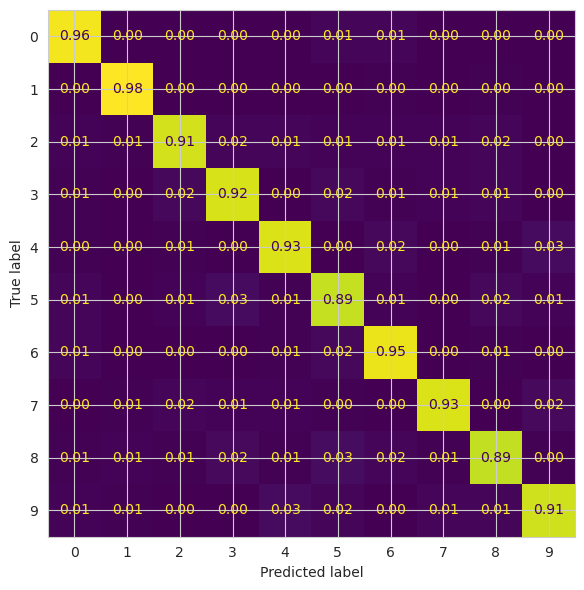

In [64]:
# Confusion matrix - row normalization
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize="true",
    values_format=".2f",
    ax=ax
)
ax.images[0].colorbar.remove()
fig.tight_layout()
fig.savefig(f"ann_confusion_matrix_row_normalize_fulldata_{flag_full_dataset}_{n_hidden}.png", dpi=300)
fig.show()